## 3D reconstruction from cropped lidar .tif file 

In [1]:
%matplotlib inline

import numpy as np
import open3d as o3d
import rasterio as rio
from rasterio.plot import plotting_extent, show, show_hist, reshape_as_image
import matplotlib.pyplot as plt
import shapely
import pandas as pd
import geopandas
import gdal
import xarray as xr

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import cartopy as cp

#### function for converting tif to xyz

In [2]:
def tiff_to_xyz(my_path):
    import os
    import subprocess

  # What/Where to load and save
    source_directory = my_path
    target_directory = my_path
  # Create dir for processed files
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
  # Find all tif
    file_names = [files for files in os.listdir(source_directory) if files.endswith(".tif")]

    for file_name in file_names:

      # Convert tif to XYZ
        gdal_command = "gdal_translate -of XYZ \"" + source_directory + "\\" + file_name + "\" \"" + target_directory + "\\" + file_name[:-3] + "xyz" + "\""
        subprocess.call(gdal_command)

    print("All done!")

#### constructing CHM (canpy height model) files (not used) 

In [3]:
# dsm_fl = rio.open('../Data/DHMVIIDSMRAS1m_k01/GeoTIFF/DHMVIIDSMRAS1m_k01.tif')

# with rio.open('../Data/DHMVIIDSMRAS1m_k01/GeoTIFF/DHMVIIDSMRAS1m_k01.tif') as srcA:
#     dsm_fl_im = srcA.read(1, masked=True)
#     dsm_fl_ext = rio.plot.plotting_extent(srcA)

In [4]:
# dtm_fl = rio.open('../Data/DHMVIIDTMRAS1m_k01/GeoTIFF/DHMVIIDTMRAS1m_k01.tif')

# with rio.open('../Data/DHMVIIDTMRAS1m_k01/GeoTIFF/DHMVIIDTMRAS1m_k01.tif') as srcB:
#     dtm_fl_im = srcB.read(1, masked=True)
#     dtm_fl_ext = rio.plot.plotting_extent(srcB)

In [5]:
# chm_fl_im = dsm_fl_im - dtm_fl_im
# chm_fl_im


#### tif opening and slicing using xarray (not used)

In [6]:
essai = xr.open_rasterio('../api/src/data/DSM_vlaanderen/DHMVIIDSMRAS1m_k09/GeoTIFF/DHMVIIDSMRAS1m_k09.tif')

In [7]:
essai

<xarray.DataArray (band: 1, y: 20000, x: 32000)>
[640000000 values with dtype=float32]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 2.38e+05 2.38e+05 2.38e+05 ... 2.18e+05 2.18e+05
  * x        (x) float64 1.94e+05 1.94e+05 1.94e+05 ... 2.26e+05 2.26e+05
Attributes:
    transform:      (1.0, 0.0, 194000.0, 0.0, -1.0, 238000.0)
    crs:            +init=epsg:31370
    res:            (1.0, 1.0)
    is_tiled:       1
    nodatavals:     (-9999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    VERTICAL_SRS:   EPSG:5110

In [8]:
essai  = essai.assign_coords(band=("band", ["one"]))

In [9]:
(199414.11489207728, 223588.5598308323)


(199414.11489207728, 223588.5598308323)

In [10]:
zoom = essai[0].sel(x=slice(199400.11489207728, 199428.11489207728),y=slice(223602.5598308323, 223574.5598308323)) #.plot.imshow()

In [11]:
zoom

<xarray.DataArray (y: 28, x: 28)>
array([[26.43, 26.46, 26.49, ..., 26.69, 26.74, 26.74],
       [26.4 , 26.43, 26.47, ..., 26.72, 26.75, 26.76],
       [26.39, 26.42, 26.45, ..., 26.74, 26.76, 26.78],
       ...,
       [26.24, 26.19, 26.21, ..., 31.06, 30.57, 30.07],
       [26.26, 26.23, 26.2 , ..., 31.4 , 30.91, 30.4 ],
       [26.28, 26.26, 26.2 , ..., 31.76, 31.26, 30.74]], dtype=float32)
Coordinates:
    band     <U3 'one'
  * y        (y) float64 2.236e+05 2.236e+05 2.236e+05 ... 2.236e+05 2.236e+05
  * x        (x) float64 1.994e+05 1.994e+05 1.994e+05 ... 1.994e+05 1.994e+05
Attributes:
    transform:      (1.0, 0.0, 194000.0, 0.0, -1.0, 238000.0)
    crs:            +init=epsg:31370
    res:            (1.0, 1.0)
    is_tiled:       1
    nodatavals:     (-9999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    VERTICAL_SRS:   EPSG:5110

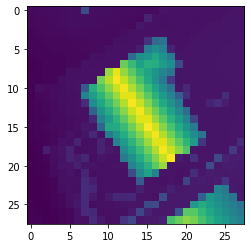

In [12]:
plt.imshow(zoom)

#### tif clip and crop with target polygon 

In [13]:
with rio.open('../api/src/data/DSM_vlaanderen/DHMVIIDSMRAS1m_k09/GeoTIFF/DHMVIIDSMRAS1m_k09.tif') as srcA:
    dsm_fl_im = srcA.read(1, masked=True)
    dsm_fl_ext = rio.plot.plotting_extent(srcA)  # srcA.bounds
    dsm_fl_profile = srcA.profile
    dsm_fl_shape = srcA.shape
    dsm_fl_crs = srcA.crs
    dsm_fl_meta = srcA.meta

    

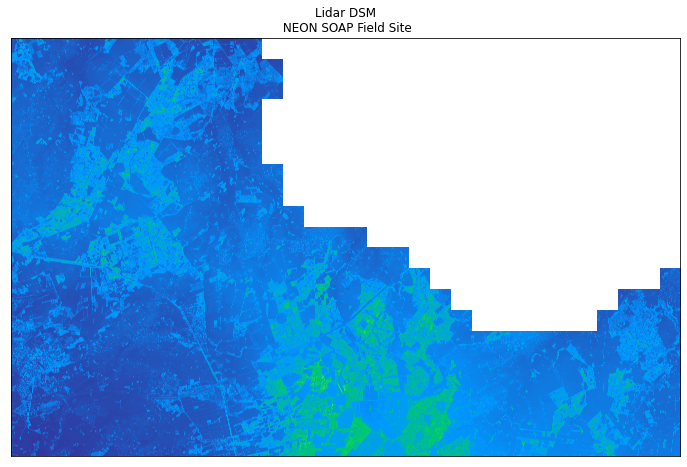

In [14]:
ep.plot_bands(dsm_fl_im,
               cmap='terrain',
               extent=dsm_fl_ext,
               title="Lidar DSM\n NEON SOAP Field Site",
               cbar=False);

In [15]:
from shapely.geometry import Point
test = Point(199414.11489207728, 223588.5598308323)
buf = test.buffer(20, cap_style=3)

In [16]:
# buf.type

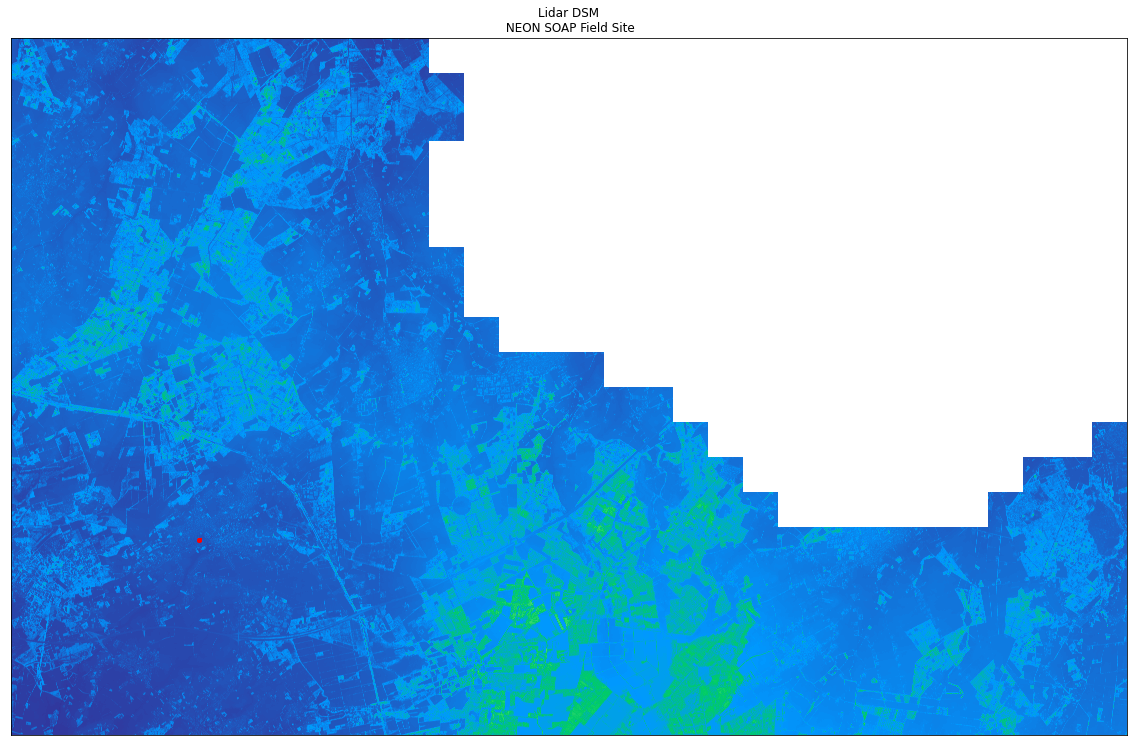

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
ep.plot_bands(dsm_fl_im,
            cmap='terrain',
            extent=dsm_fl_ext,
            title="Lidar DSM\n NEON SOAP Field Site",
            ax=ax,
            cbar=False)
plt.plot(*buf.exterior.xy, lw=4, color='red')

first way to crop (not used)

In [18]:
with rio.open('../api/src/data/DSM_vlaanderen/DHMVIIDSMRAS1m_k09/GeoTIFF/DHMVIIDSMRAS1m_k09.tif') as srcA:
    crop, srcA_meta = es.crop_image(srcA, [buf])

second way to crop

In [68]:
with rio.open('../api/src/data/DSM_vlaanderen/DHMVIIDSMRAS1m_k09/GeoTIFF/DHMVIIDSMRAS1m_k09.tif') as srcA:
    out_image, out_transform = rio.mask.mask(srcA, [buf], crop=True, filled=False)
    profile = srcA.profile
    meta = srcA.meta
    ext = plotting_extent(srcA)

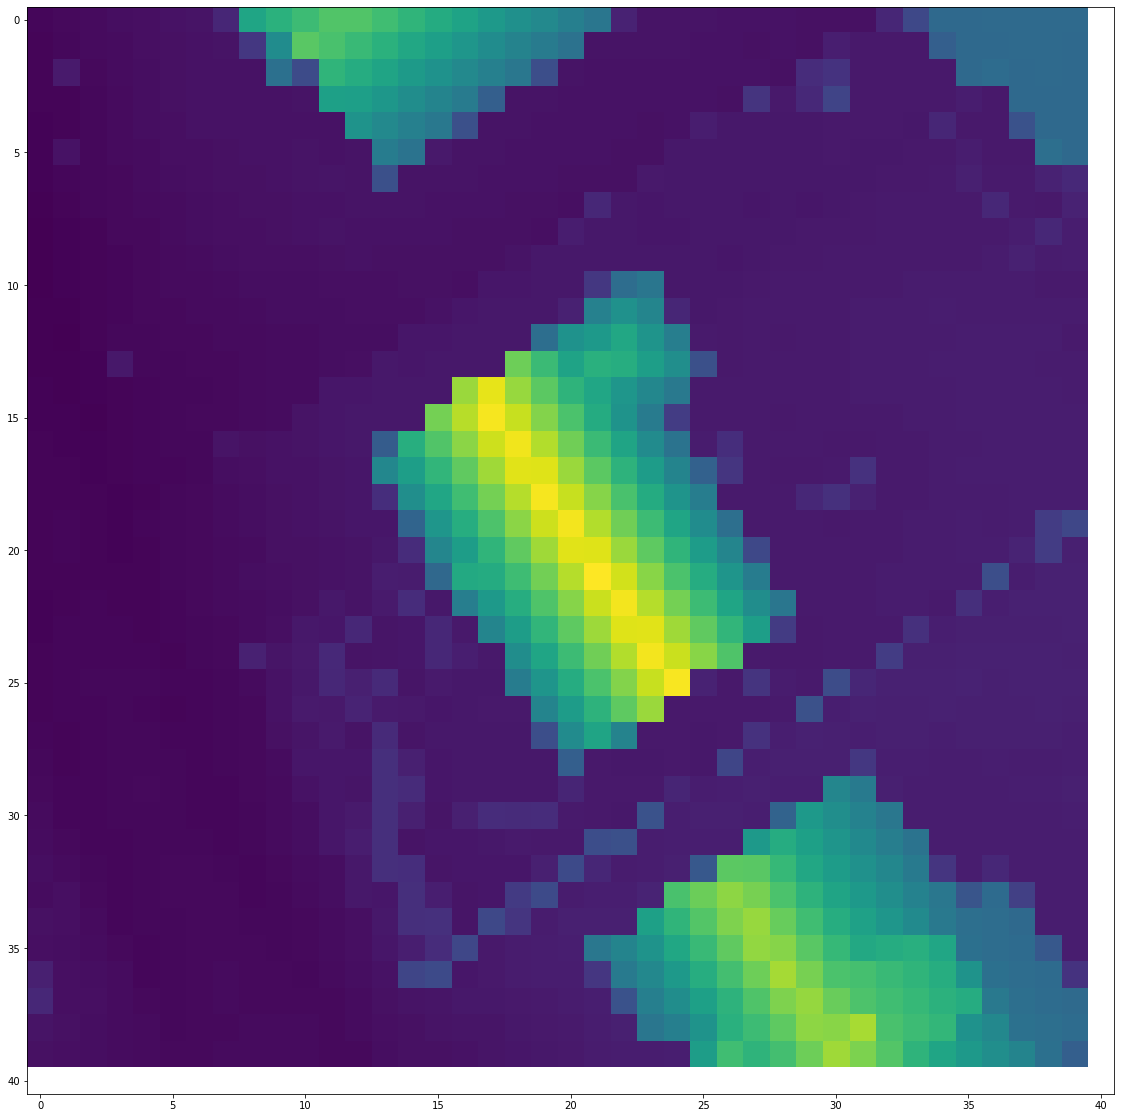

<AxesSubplot:>

In [69]:
plt.figure(figsize=(20,20))
show(out_image)

In [70]:
# out_image

In [71]:
out_image.shape

(1, 41, 41)

In [72]:
out_image.squeeze().shape

(41, 41)

increasing resolution with linear interpolation 

In [73]:
import scipy.interpolate as sci

x_in=np.arange(0,41,1)
y_in=np.arange(0,41,1)
x_out= np.arange(0,41,0.25)
y_out= np.arange(0,41,0.25)


f = sci.RectBivariateSpline(x_in, y_in, out_image.squeeze())
outintercub = f(x_out, y_out)


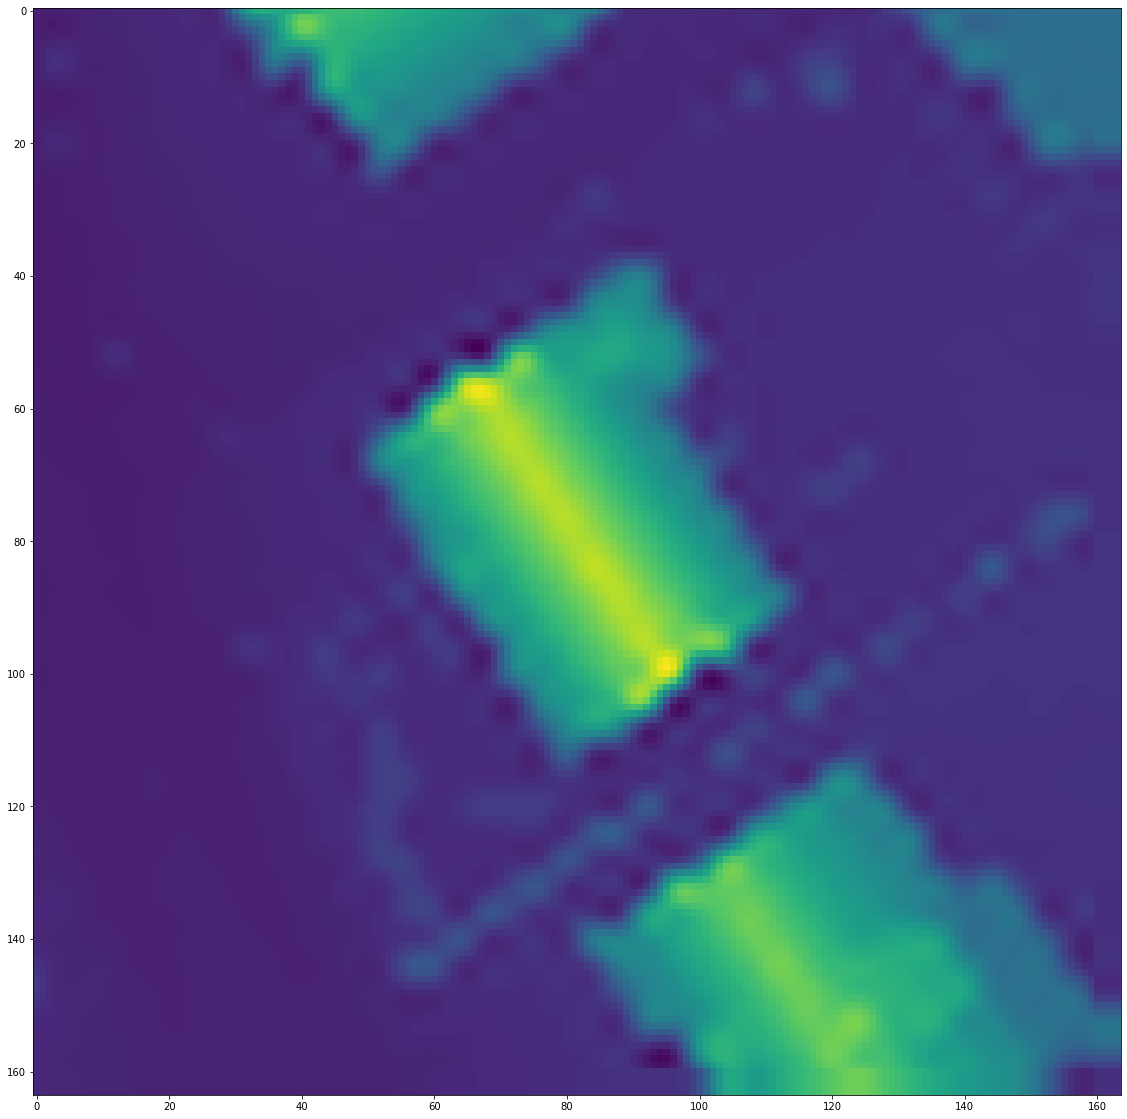

<AxesSubplot:>

In [74]:
plt.figure(figsize=(20,20))
show(outintercub)

In [ ]:
outinter.shape

In [ ]:
outinter = outinter *3

In [ ]:
outinter.shape

In [ ]:
plt.figure(figsize=(20,20))
show(outinter)

In [ ]:
outinter.shape

In [ ]:
outinter = np.where(outinter>np.percentile(outinter, 99.7), np.percentile(outinter, 99.7), outinter)


In [ ]:
outinter.shape

In [ ]:
plt.figure(figsize=(20,20))
show(outinter)

In [ ]:
# outinter = outinter * 3

In [ ]:
outinter.shape

updating metadate of output file + save as tif

In [ ]:
outinter=outinter.reshape(1,outinter.shape[0],outinter.shape[1])

In [ ]:
meta.update({"driver": "GTiff",
                 "height": outinter.shape[1],
                 "width": outinter.shape[2],
                 "transform": out_transform})

In [ ]:
out_image.dtype

In [ ]:
outinter.dtype

In [ ]:
outinter=outinter.astype('float32')

In [ ]:
with rio.open("../api/src/data/output/gouwberg19.tif", "w", **meta) as dest:
    dest.write(outinter)

#### 3D reconstruction 

In [96]:
tiff_to_xyz("../api/src/Data/output/")

All done!


point cloud construction and visualization 

In [97]:
input_path="../api/src/Data/output/"
output_path="../api/src/Data/output/"
dataname="gouwberg19.xyz"
point_cloud= np.loadtxt(input_path+dataname,skiprows=1)


In [98]:
point_cloud

array([[1.993955e+05, 2.236085e+05, 9.400000e+01],
       [1.993965e+05, 2.236085e+05, 9.400000e+01],
       [1.993975e+05, 2.236085e+05, 9.400000e+01],
       ...,
       [1.995515e+05, 2.234495e+05, 1.050000e+02],
       [1.995525e+05, 2.234495e+05, 1.050000e+02],
       [1.995535e+05, 2.234495e+05, 1.050000e+02]])

In [99]:
point_cloud.shape

(25599, 3)

In [100]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

True

In [102]:
o3d.visualization.draw_geometries([pcd])


RuntimeError: [Open3D ERROR] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 

Reconstruction with poisson algorithm

In [ ]:
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    poisson_mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, width=0,depth=8, scale=1.1,linear_fit =True) #,, width=0, scale=2, linear_fit=False)[0]

In [ ]:
densities = np.asarray(densities)
density_colors = plt.get_cmap('viridis')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]
density_mesh = o3d.geometry.TriangleMesh()
density_mesh.vertices = poisson_mesh.vertices
density_mesh.triangles = poisson_mesh.triangles
density_mesh.triangle_normals = poisson_mesh.triangle_normals
density_mesh.vertex_colors = o3d.utility.Vector3dVector(density_colors)

In [105]:
vertices_to_remove = densities < np.quantile(densities, 0.01)
density_mesh.remove_vertices_by_mask(vertices_to_remove)

In [108]:
o3d.visualization.draw_geometries([density_mesh])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


RuntimeError: [Open3D ERROR] GLFW Error: WGL: Failed to make context current: The handle is invalid. 

Reconstruction with ball pivoting algorithm

In [ ]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 10 * avg_dist

In [ ]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))

In [ ]:
dec_mesh = bpa_mesh.simplify_quadric_decimation(1000000)

In [ ]:
dec_mesh.remove_degenerate_triangles()
dec_mesh.remove_duplicated_triangles()
dec_mesh.remove_duplicated_vertices()
dec_mesh.remove_non_manifold_edges()

In [ ]:
o3d.visualization.draw_geometries([bpa_mesh])

In [ ]:
o3d.visualization.draw_geometries([dec_mesh])

### essai reconstruction 

In [75]:
with rio.open('../api/src/data/DSM_vlaanderen/DHMVIIDSMRAS1m_k09/GeoTIFF/DHMVIIDSMRAS1m_k09.tif') as srcA:
    out_image, out_transform = rio.mask.mask(srcA, [buf], crop=True, filled=False)
    profile = srcA.profile
    meta = srcA.meta
    ext = plotting_extent(srcA)

In [76]:
out_image.shape

(1, 41, 41)

In [77]:
out_image = out_image[0,:-1,:-1]

In [78]:
out_image.shape

(40, 40)

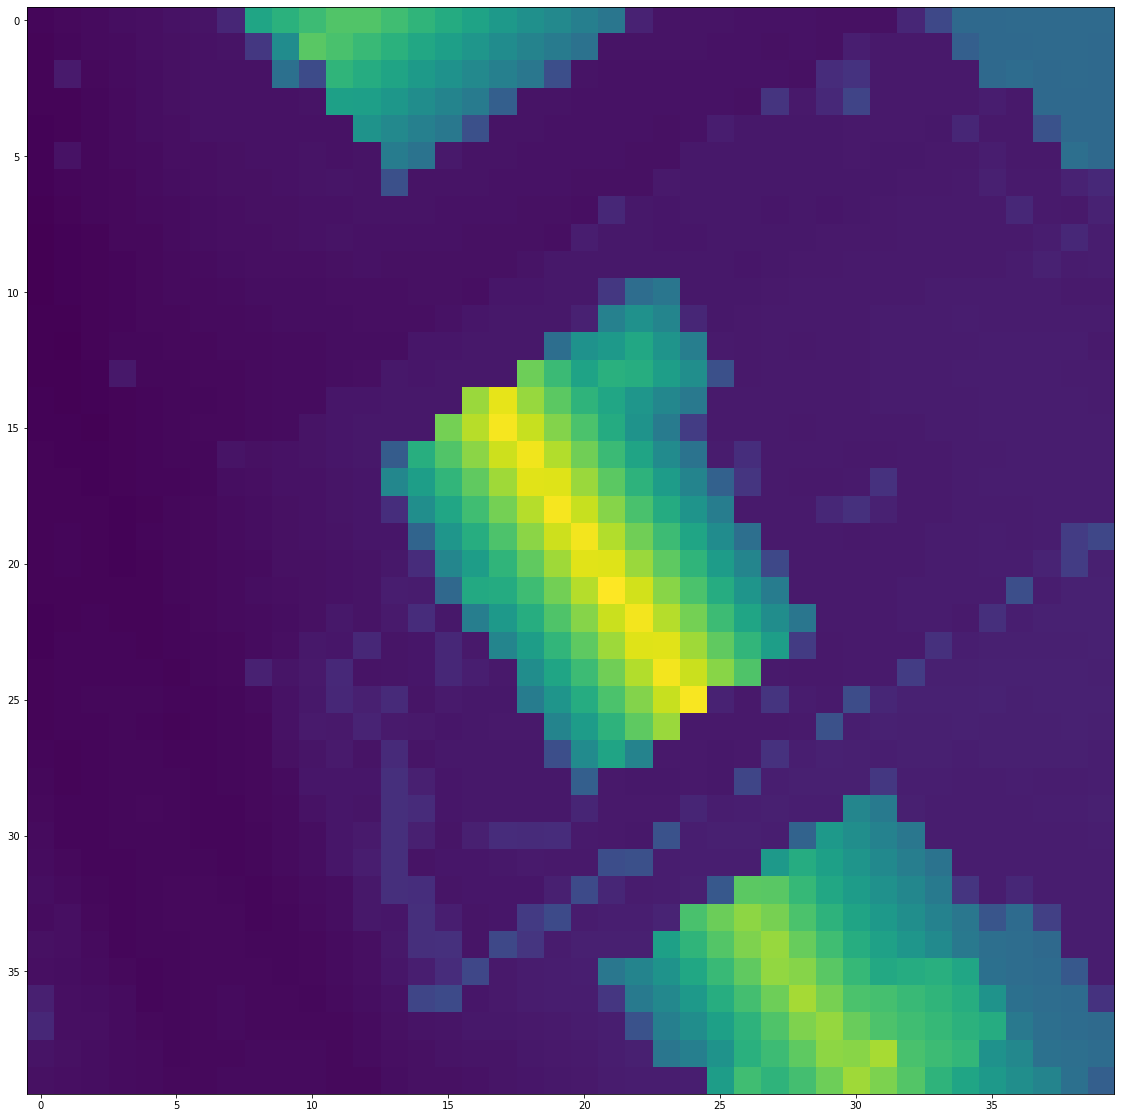

<AxesSubplot:>

In [79]:
plt.figure(figsize=(20,20))
show(out_image)

In [80]:
out_image.min()

26.0

In [81]:
out_image.max()

36.65

In [82]:
out_image = out_image *2

In [83]:
# out_image = np.round(out_image, 0)

In [84]:
out_image.max()

73.3

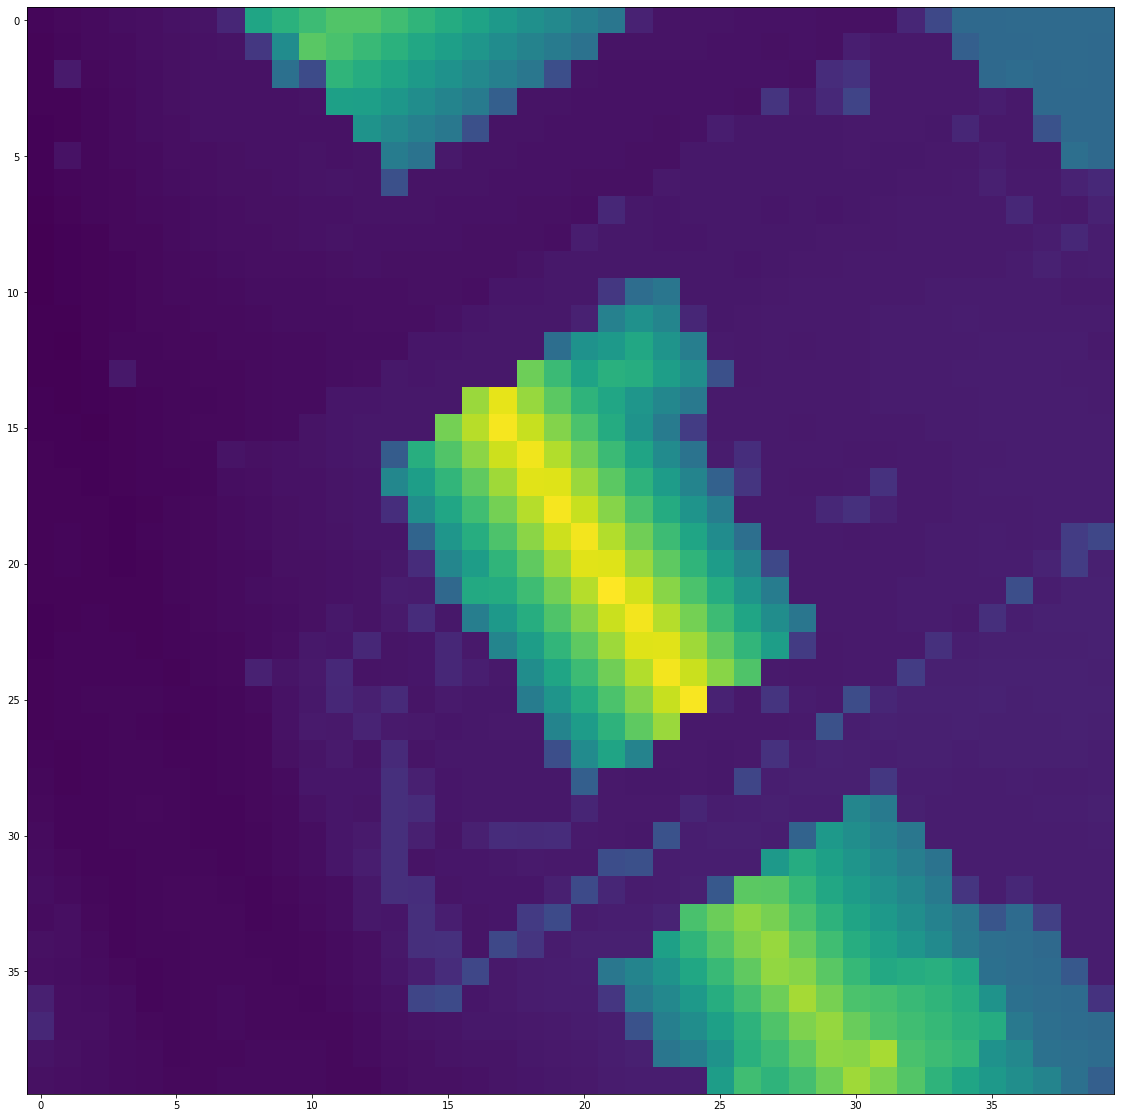

<AxesSubplot:>

In [85]:
plt.figure(figsize=(20,20))
show(out_image)

In [86]:
# outinter2 = np.where(outinter > np.percentile(outinter, 70),outinter, np.nan)

In [87]:
import scipy.interpolate as sci

x_in=np.arange(0,40,1)
y_in=np.arange(0,40,1)
x_out= np.arange(0,40,0.25)
y_out= np.arange(0,40,0.25)


f = sci.interp2d(x_in, y_in, out_image.squeeze(), kind='linear')
outintercub = f(x_out, y_out)

In [88]:
outintercub = outintercub * 1.8

In [89]:
outintercub = np.where(outintercub>np.percentile(outintercub, 99.6), np.percentile(outintercub, 99.6), outintercub)


In [90]:
outintercub = np.round(outintercub, 0)

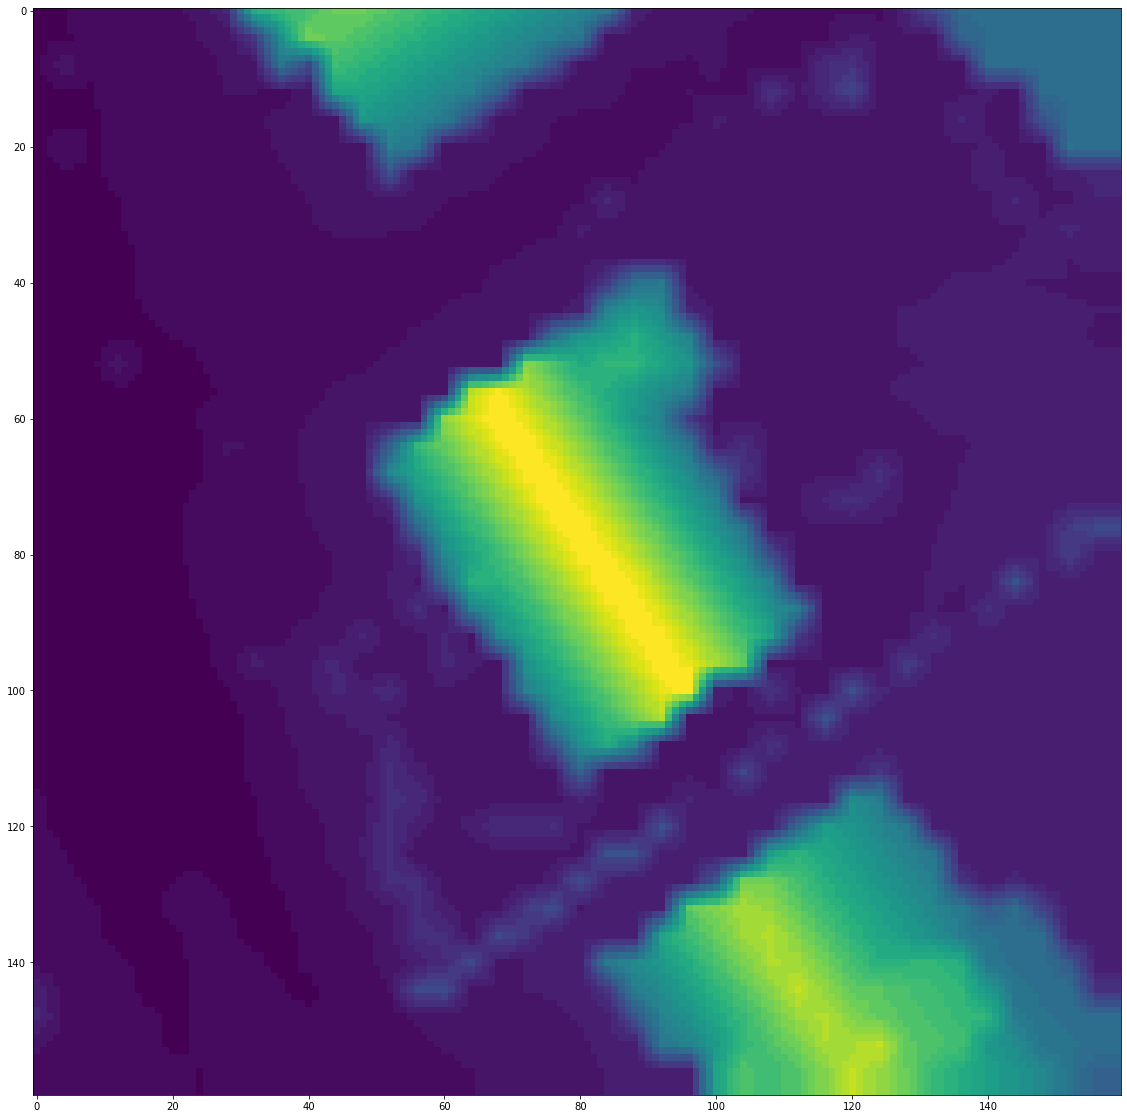

<AxesSubplot:>

In [91]:
plt.figure(figsize=(20,20))
show(outintercub)

In [92]:
outintercub=outintercub.reshape(1,outintercub.shape[0],outintercub.shape[1])

In [93]:
meta.update({"driver": "GTiff",
                 "height": outintercub.shape[1],
                 "width": outintercub.shape[2],
                 "transform": out_transform})

In [94]:
outintercub=outintercub.astype('float32')

In [95]:
with rio.open("../api/src/data/output/gouwberg19.tif", "w", **meta) as dest:
    dest.write(outintercub)